# CH02.2. **사전-학습 정보(Pre-train Information)**

## 00. **작업 환경 설정**

#### 00.0. **사전 변수 설정**

In [1]:
SEED_NUM = 2025
BATCH_SIZE = 32
EPOCH_NUM = 5000
USE_PRETRAIN_YN = 'Y' # 'Y' or 'N'
MODEL_PTH = '../../model/bostonRegGPU.pt'

#### 00.1. **라이브러리 호출 및 옵션 설정**

In [2]:
#(1) Import libraries
import os
import random
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
import torch

#(2) Set options
os.environ['PYTHONHASHSEED'] = str(SEED_NUM)
random.seed(a=SEED_NUM)
np.random.seed(seed=SEED_NUM)
torch.use_deterministic_algorithms(mode=True)
torch.manual_seed(seed=SEED_NUM)

#### 00.2. **사용자정의함수 정의**

In [3]:
#(1) Define `describe_df()` function
def describe_df(df:pd.DataFrame) :
    output = pd.DataFrame(data={
        'dataType'     : df.dtypes,
        'nullCount'    : df.isnull().sum(),
        'nonNullCount' : (df.shape[0]-df.isnull().sum()),
        'uniqueCount'  : df.nunique()
    })
    return output

#(2) Define `compute_rmse()` function
def compute_rmse(model:torch.nn.Module, loader:torch.utils.data.DataLoader) :
    model.eval()
    with torch.no_grad() : 
        square_sum = 0
        instance_num = 0
        for inputs, targets in loader :
            preds = model(x=inputs)
            square_sum += torch.sum(input=(preds - targets)**2).item()
            instance_num += len(targets)
    model.train()
    output = np.sqrt(square_sum/instance_num)
    return output

#### 00.3. **클래스 정의**

In [4]:
#(1) Define `MyTensorDataset` class
class MyTensorDataset(torch.utils.data.Dataset) :
    def __init__(self, df:pd.DataFrame, pred_label_nm:'str', data_type:torch.dtype=torch.float32) :
        self.feature = torch.tensor(data=df.drop(labels=pred_label_nm, axis=1).values, dtype=data_type)
        self.label = torch.tensor(data=df.loc[:, pred_label_nm].values, dtype=data_type).reshape(shape=(-1, 1))
        self.len = self.label.shape[0]
    def __getitem__(self, index) :
        return self.feature[index], self.label[index]
    def __len__(self) :
        return self.len

#(2) Define `MyRegressionModel` class
class MyRegressionModel(torch.nn.Module) :
    def __init__(self) :
        super().__init__()
        dims = [13, 128, 64, 32]
        self.layers = torch.nn.ModuleDict()
        for i in range(len(dims)-1) :
            fc_block = torch.nn.ModuleList(modules=[
                torch.nn.Linear(in_features=dims[i], out_features=dims[i+1]),
                torch.nn.BatchNorm1d(num_features=dims[i+1]),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.2)
            ])
            self.layers[f'fc_{i}'] = fc_block
        layer = torch.nn.Linear(in_features=dims[-1], out_features=1)
        self.layers[f'fc_{i+1}'] = layer
    def forward(self, x) :
        _layers = list(self.layers.values())
        for fc_block in _layers[:-1]:
            for layer in fc_block:
                x = layer(x)
        x = _layers[-1](x)
        return x

<b></b>

## 01. **데이터셋 로드 및 EDA**

#### 01.1. **데이터셋 로드**

In [5]:
boston_raw = pd.read_csv(filepath_or_buffer='../../data/boston.csv', index_col=[0])

#### 01.2. **EDA**

In [6]:
#(1) Display `boston_raw`
# boston_raw.head(n=10)

In [7]:
#(2) Describe `boston_raw`
# describe_df(df=boston_raw)

In [8]:
#(3) Check the statistics of `boston_raw`
# boston_raw.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).transpose()

<b></b>

## 02. **데이터셋 전처리**

#### 02.1. **학습 및 검증 데이터셋 분리**

In [9]:
boston_train, boston_test = sklearn.model_selection.train_test_split(boston_raw, train_size=0.7, random_state=SEED_NUM)

#### 02.2. **텐서 변환**

In [10]:
boston_train = MyTensorDataset(df=boston_train, pred_label_nm='Price', data_type=torch.float32)
boston_test = MyTensorDataset(df=boston_test, pred_label_nm='Price', data_type=torch.float32)

#### 02.3. **데이터로더 변환**

In [11]:
boston_train_loader = torch.utils.data.DataLoader(dataset=boston_train, batch_size=BATCH_SIZE, shuffle=True)
boston_test_loader = torch.utils.data.DataLoader(dataset=boston_test, batch_size=BATCH_SIZE, shuffle=True)

<b></b>

## 03. **모델 구축 및 학습**

#### 03.1. **모델 정의**

In [12]:
#(1) Define `model`
model = MyRegressionModel().to(dtype=torch.float32)

#(2) Display `model`
# model

In [13]:
#(3)
# dummy = torch.randn(size=[BATCH_SIZE]+list(boston_train[0][0].shape))
# torchinfo.summary(model=model, input_data=dummy)

In [14]:
#(3) Define loss function
criterion = torch.nn.MSELoss()

#(4) Define optimizer(optimization method)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=1e-7)

#(5) Define Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.1)

#### 03.2. **학습 전 변수 정의(사전학습 활용)**

In [15]:
batch_cnt = len(boston_train_loader)
if USE_PRETRAIN_YN == 'Y' :
    checkpoint = torch.load(f=MODEL_PTH)
    model.load_state_dict(state_dict=checkpoint['model'])
    optimizer.load_state_dict(state_dict=checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    loss_hist = checkpoint['loss_hist']
    best_loss = loss_hist[-1]
else :
    epoch = 0
    loss_hist = []
    best_loss = float('inf')
print(f">> Epoch={epoch}, Train Loss={best_loss}")

>> Epoch=76, Train Loss=0.008695439047490558


#### **(`PLUS`)** `.pt` 파일은 PyTorch에서 모델의 상태(가중치, 옵티마이저 상태 등)를 저장하거나 불러올 때 사용하는 딕셔너리 구조임

#### 03.3. **모델 학습**

In [16]:
progress_bar = tqdm.trange(epoch, EPOCH_NUM)
for epoch in progress_bar : 
    running_loss = 0.0
    model.train()
    for inputs, targets in boston_train_loader :
        optimizer.zero_grad() 
        outputs = model(x=inputs)
        loss = criterion(input=outputs, target=targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss_avg = running_loss / batch_cnt
    loss_hist.append(running_loss_avg)
    if running_loss_avg < best_loss :
        best_loss = running_loss_avg
        torch.save(
            obj={
                'epoch'     : epoch,
                'loss_hist' : loss_hist,
                'model'     : model.state_dict(),
                'optimizer' : optimizer.state_dict()
            }, 
            f=MODEL_PTH
        )
    scheduler.step()
    progress_bar.set_postfix(ordered_dict={'epoch':epoch+1, 'loss':running_loss_avg}) 

100%|██████████| 4924/4924 [02:59<00:00, 27.45it/s, epoch=5000, loss=0.0143] 


<b></b>

## 04. **모델 평가**

#### 04.1. **최적 성능 모델 로드**

In [17]:
checkpoint = torch.load(f=MODEL_PTH)
model.load_state_dict(state_dict=checkpoint['model'])
print(f'>> Epoch : {checkpoint["epoch"]}, Loss : {checkpoint["loss_hist"][-1]}')

>> Epoch : 76, Loss : 0.008695439047490558


#### 04.2. **학습 손실(Traing Loss) 확인**

In [18]:
#(1) Check RMSE
rmse_train = compute_rmse(model=model, loader=boston_train_loader)
print(f'>> Train RMSE: {rmse_train}')

>> Train RMSE: 0.07999100349267704


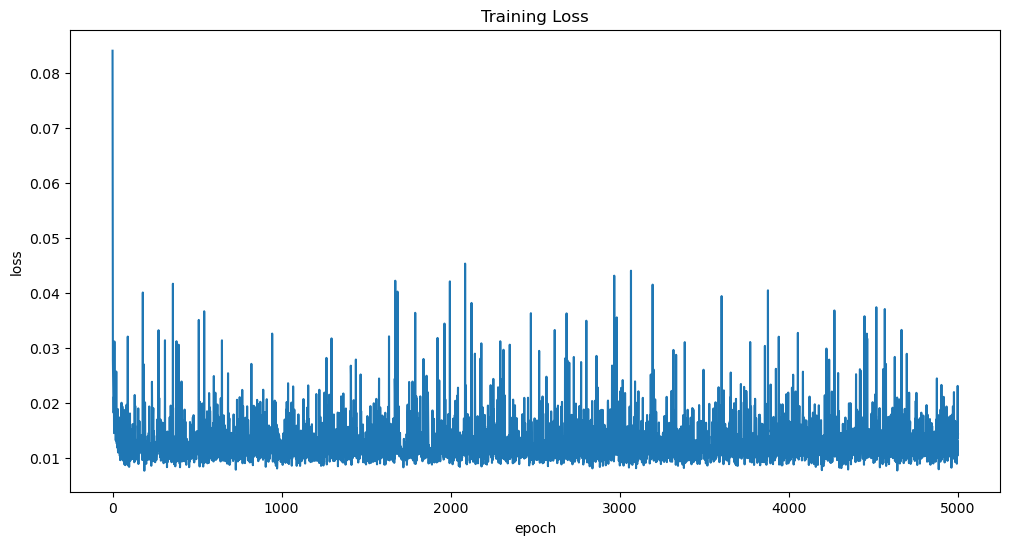

In [19]:
#(2) Plot traing loss
plt.figure(figsize=(12, 6))
plt.title(label='Training Loss')
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.plot(loss_hist)
plt.show()

#### 04.3. **성능 평가**

In [20]:
rmse_test = compute_rmse(model=model, loader=boston_test_loader)
print(f'>> Test RMSE : {rmse_test}')

>> Test RMSE : 0.10622469300600085
